## Coding 3 - Final Project

This project aims to explore how autoencoders can be trained and used to generate new NPCs from the popular video game by Nintendo, *Animal Crossing: New Horizons* using images of the villagers in the game. 

The dataset used in this notebook is a series of images of the animal villagers found in the game. The dataset is found on Kaggle and is called "Animal Crossing: New Horizons | All Villagers" (link: https://www.kaggle.com/datasets/jahysama/animal-crossing-new-horizons-all-villagers). The data is comprised of 392 images of different sizes.

The aim of this project is to train autoencoders to (1) recreate the original images and (2) generate new images using the latent vector embeddings. 

This notebook uses code from the following sources:
1. https://blog.keras.io/building-autoencoders-in-keras.html
2. The 'ConvolutionalVAE' notebook from week 4 of class
3. ChatGPT for help with debugging the models, image processing and visualisation
4. Help from the wonderful Coding 3 team at CCI!

## Setup

Below setup code is mainly from the ConvolutionalVAE notebook from week 4

In [1]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers.legacy import Adam

from keras.layers import Lambda, Input, Dense
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from keras.layers import Reshape, Flatten, BatchNormalization, Activation

from keras.models import Model
from keras.losses import mse, binary_crossentropy

from keras import backend as K
from keras import optimizers

### Importing data and process the data for the models 

Import the villagers images dataset, and perform the necessary pre-processing steps.

In [2]:
directory = "villagers"

img_files = []
img_files += [os.path.join(directory, img) for img in os.listdir(directory)]

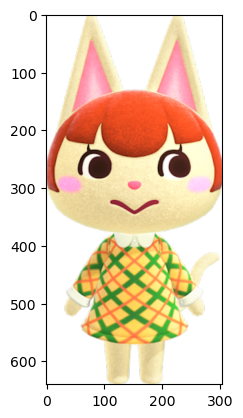

In [3]:
# Show one image for testing 

img = plt.imread(img_files[88]) # random choice 
plt.imshow(img)

## Processing of data and creating training/test sets 

Because the images in the dataset are of different sizes, it's important to resize them all to the same dimensions. The dimensions used in this notebook are (640, 400, 4).

Once the images are all of the correct size, create the training and test sets from the data. 

ChatGPT helped with the below code.  

In [4]:
# Resize the images
villagers_imgs = []
height = 640
width = 400

for file in img_files:
    
    #skip bc of weird file
    if(file==(directory + "/.DS_Store")):
        continue
    
    img = plt.imread(file)
    img = cv2.resize(img, (width, height))
    
    villagers_imgs.append(img)

villagers_array = np.array(villagers_imgs)

(313, 640, 400, 4)
(79, 640, 400, 4)


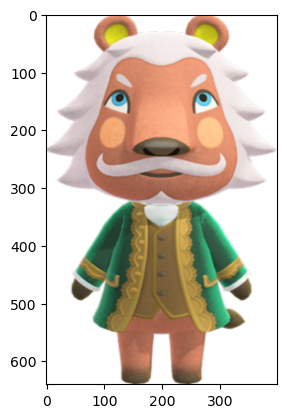

In [5]:
X_train, X_test = train_test_split(villagers_array, test_size=0.2)

print(X_train.shape)
print(X_test.shape)

plt.imshow(X_test[1]) #plot one to check it works


As per the tutorial https://blog.keras.io/building-autoencoders-in-keras.html, flatten the training and test data.

In [6]:
#X_train = X_train.astype('float32') / 255.
#X_test = X_test.astype('float32') / 255.

print(X_train.shape)
print(X_test.shape)

# Flatten into 1024000 
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

print(X_train.shape)
print(X_test.shape)

(313, 640, 400, 4)
(79, 640, 400, 4)
(313, 1024000)
(79, 1024000)


### Building a simple autoencoder as a start

To begin, I built a very simple autoencoder using the tutorial from Keras: "Let's build the simplest possible autoencoder": https://blog.keras.io/building-autoencoders-in-keras.html

In [7]:
encoding_dim = 64
#input_shape = (640, 400, 4)
input_shape=(1024000,)

epochs = 50
batch_size = 64

inputs = Input(shape=input_shape)

encoded = Dense(encoding_dim, activation='relu')(inputs)
decoded = Dense(input_shape[0], activation='sigmoid')(encoded)

# input -> reconstruction 
autoencoder = Model(inputs, decoded)
print(decoded.shape)

# Encoder
# input -> encoded representation
encoder = Model(inputs, encoded)

# Decoder
encoded_input = Input(shape=encoding_dim)

# last layer of autoencoder model
decoder_layer = autoencoder.layers[-1]

# Create decoder model
# encoded rep -> reconstruction 
decoder = Model(encoded_input, decoder_layer(encoded_input))

# Compilation
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
print(autoencoder.summary())

# Train
autoencoder.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, 
                shuffle=True, validation_data=(X_test, X_test))


Metal device set to: Apple M1 Max
(None, 1024000)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024000)]         0         
                                                                 
 dense (Dense)               (None, 64)                65536064  
                                                                 
 dense_1 (Dense)             (None, 1024000)           66560000  
                                                                 
Total params: 132,096,064
Trainable params: 132,096,064
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50


/Users/evahayek/miniforge3/envs/coding3/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2023-06-15 22:23:52.164977: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


5/5 [==============================] - 2s 310ms/step - loss: 0.6565 - val_loss: 0.5354
Epoch 2/50
5/5 [==============================] - 1s 210ms/step - loss: 0.5254 - val_loss: 0.5109
Epoch 3/50
5/5 [==============================] - 1s 201ms/step - loss: 0.5107 - val_loss: 0.5060
Epoch 4/50
5/5 [==============================] - 1s 206ms/step - loss: 0.5063 - val_loss: 0.5023
Epoch 5/50
5/5 [==============================] - 1s 204ms/step - loss: 0.5029 - val_loss: 0.4985
Epoch 6/50
5/5 [==============================] - 1s 204ms/step - loss: 0.5002 - val_loss: 0.4975
Epoch 7/50
5/5 [==============================] - 1s 207ms/step - loss: 0.4975 - val_loss: 0.4941
Epoch 8/50
5/5 [==============================] - 1s 202ms/step - loss: 0.4939 - val_loss: 0.4905
Epoch 9/50
5/5 [==============================] - 1s 206ms/step - loss: 0.4910 - val_loss: 0.4880
Epoch 10/50
5/5 [==============================] - 1s 205ms/step - loss: 0.4888 - val_loss: 0.4861
Epoch 11/50
5/5 [=============

### Visualise results

In [8]:
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)

3/3 [==============================] - 0s 12ms/step


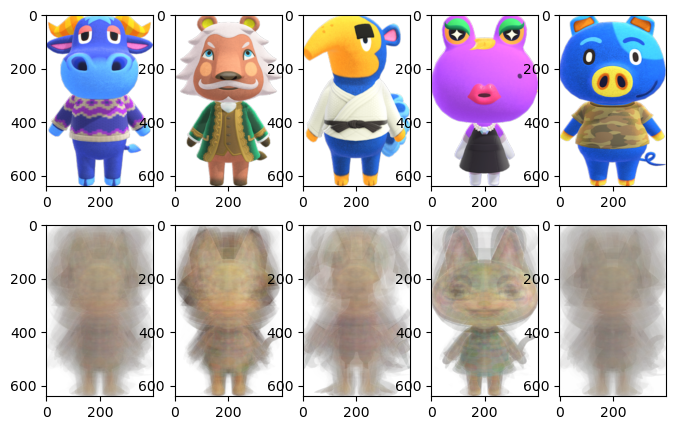

In [9]:
total = 5
plt.figure(figsize=(8, 5))

for i in range(total):
    
    # Original
    ax = plt.subplot(2, total, i+1)
    plt.imshow(X_test[i].reshape(height, width, 4))
    
    # Autoencoder result
    ax = plt.subplot(2, total, i+1+total)
    plt.imshow(decoded_imgs[i].reshape(height, width, 4))

plt.show()

### Some notes on the results

1. Using an encoding_dim value of 32 leads to a loss of 0.4498, and images that aren't so accurate
2. Using an encoding_dim value of 64 leads to a loss of 0.4318 (binary_crossentropy) 

## Convolutional Autoencoder - Part 1

Next, I followed the same tutorial to create a convolutional autoencoder.

Using the tutorial from https://blog.keras.io/building-autoencoders-in-keras.html, 'Convolutional Autoencoders'

In [24]:
input_shape = (640, 400, 4)
inputs = Input(shape=input_shape)

# encoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)

encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(4, (3, 3), activation='relu', padding='same')(x)

autoencoder = Model(inputs, decoded)

print(autoencoder.summary())
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 640, 400, 4)]     0         
                                                                 
 conv2d_21 (Conv2D)          (None, 640, 400, 16)      592       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 320, 200, 16)     0         
 2D)                                                             
                                                                 
 conv2d_22 (Conv2D)          (None, 320, 200, 8)       1160      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 160, 100, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 160, 100, 8)       584 

In [25]:
X_train = X_train.reshape((len(X_train), 640, 400, 4))
X_test = X_test.reshape((len(X_test), 640, 400, 4))

print(X_train.shape)
print(X_test.shape)

epochs=25
batch_size=128

autoencoder.fit(X_train, X_train, epochs=epochs, 
                batch_size=batch_size, shuffle=True,
               validation_data=(X_test, X_test))


(313, 640, 400, 4)
(79, 640, 400, 4)
Epoch 1/25
3/3 [==============================] - 8s 2s/step - loss: 4.7118 - val_loss: 3.9155
Epoch 2/25
3/3 [==============================] - 8s 3s/step - loss: 3.6441 - val_loss: 3.3293
Epoch 3/25
3/3 [==============================] - 7s 2s/step - loss: 3.2521 - val_loss: 3.1454
Epoch 4/25
3/3 [==============================] - 7s 2s/step - loss: 3.0765 - val_loss: 2.9508
Epoch 5/25
3/3 [==============================] - 7s 2s/step - loss: 2.7791 - val_loss: 1.3172
Epoch 6/25
3/3 [==============================] - 7s 2s/step - loss: 1.1443 - val_loss: 0.8665
Epoch 7/25
3/3 [==============================] - 7s 2s/step - loss: 0.7861 - val_loss: 0.5968
Epoch 8/25
3/3 [==============================] - 7s 2s/step - loss: 0.5563 - val_loss: 0.6265
Epoch 9/25
3/3 [==============================] - 7s 2s/step - loss: 0.5756 - val_loss: 0.4648
Epoch 10/25
3/3 [==============================] - 7s 2s/step - loss: 0.4496 - val_loss: 0.4460
Epoch 11/25


In [27]:
print(X_test.shape)
print(encoded_imgs.shape)
predictions = autoencoder.predict(X_test)

(79, 640, 400, 4)
(79, 64)
3/3 [==============================] - 0s 91ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


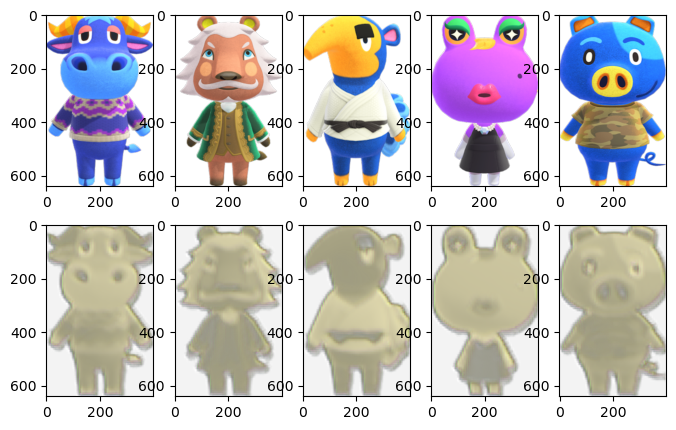

In [28]:
total = 5
plt.figure(figsize=(8, 5))

for i in range(total):
    
    # Original
    ax = plt.subplot(2, total, i+1)
    plt.imshow(X_test[i].reshape(height, width, 4))
    
    # Autoencoder result
    ax = plt.subplot(2, total, i+1+total)
    plt.imshow(predictions[i].reshape(height, width, 4))

plt.show()

## Convolutional autoencoder - Part 2


Although the results from the first convolutional autoencoder were pretty accurate, the latent vector was not sufficiently compressed. In this second convolutional autoencoder, I flattened the input to the encoder and reshaped it with Dense layers in order to compress the vector even further.

This code also comes from https://blog.keras.io/building-autoencoders-in-keras.html (same as above). ChatGPT assisted me with the required steps for the changes, but big thanks to Jasper for helping me debug and getting it to work!

In [29]:
input_shape = (640, 400, 4)
inputs = Input(shape=input_shape)
latent_dim = 100

# encoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)

#more layers

encoded = MaxPooling2D((2, 2), padding='same')(x)
# flatten
x = Flatten()(encoded) # 80, 50, 8
# dense 
x = Dense(512)(x)
latent = Dense(latent_dim, name='latent')(x)

x = Dense(80*50*8)(latent)
# print(x.shape)
x = Reshape((80,50,8))(x)

# decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(4, (3, 3), activation='relu', padding='same')(x)

autoencoder = Model(inputs, decoded)

print(autoencoder.summary())
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 640, 400, 4)]     0         
                                                                 
 conv2d_28 (Conv2D)          (None, 640, 400, 16)      592       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 320, 200, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 320, 200, 8)       1160      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 160, 100, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 160, 100, 8)       584 

In [30]:
# Reshape the training and testing sets to work with the above encoder
X_train = X_train.reshape((len(X_train), 640, 400, 4))
X_test = X_test.reshape((len(X_test), 640, 400, 4))

print(X_train.shape)
print(X_test.shape)

(313, 640, 400, 4)
(79, 640, 400, 4)


In [31]:
epochs=50
batch_size=128

autoencoder.fit(X_train, X_train, epochs=epochs, 
                batch_size=batch_size, shuffle=True,
                validation_data=(X_test, X_test))

Epoch 1/50
3/3 [==============================] - 7s 2s/step - loss: 2.9299 - val_loss: 1.7195
Epoch 2/50
3/3 [==============================] - 8s 2s/step - loss: 1.4877 - val_loss: 1.0805
Epoch 3/50
3/3 [==============================] - 8s 2s/step - loss: 0.9573 - val_loss: 0.7510
Epoch 4/50
3/3 [==============================] - 8s 2s/step - loss: 0.7191 - val_loss: 0.6560
Epoch 5/50
3/3 [==============================] - 7s 2s/step - loss: 0.6452 - val_loss: 0.6057
Epoch 6/50
3/3 [==============================] - 7s 2s/step - loss: 0.6057 - val_loss: 0.5836
Epoch 7/50
3/3 [==============================] - 7s 2s/step - loss: 0.5787 - val_loss: 0.5572
Epoch 8/50
3/3 [==============================] - 7s 2s/step - loss: 0.5560 - val_loss: 0.5447
Epoch 9/50
3/3 [==============================] - 7s 2s/step - loss: 0.5386 - val_loss: 0.5268
Epoch 10/50
3/3 [==============================] - 7s 2s/step - loss: 0.5243 - val_loss: 0.5191
Epoch 11/50
3/3 [==============================] 

In [32]:
print(X_test.shape)
print(encoded_imgs.shape)
predictions = autoencoder.predict(X_test)

(79, 640, 400, 4)
(79, 64)
3/3 [==============================] - 0s 104ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


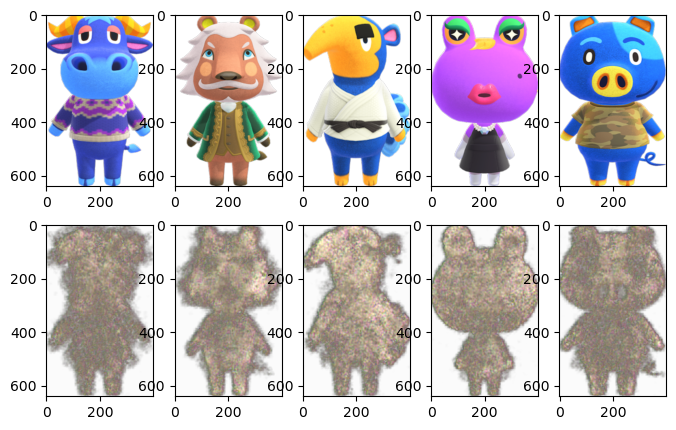

In [33]:
# Plot originals and reconstructed images

total = 5
plt.figure(figsize=(8, 5))

for i in range(total):
    
    # Original
    ax = plt.subplot(2, total, i+1)
    plt.imshow(X_test[i].reshape(height, width, 4))
    
    # Autoencoder result
    ax = plt.subplot(2, total, i+1+total)
    plt.imshow(predictions[i].reshape(height, width, 4))

plt.show()

## Variational autoencoder 

Using tutorial https://blog.keras.io/building-autoencoders-in-keras.html, 'Variational autoencoder (VAE)', as well as the notebook ConvolutionalVAE from week 4.

ChatGPT helped with tailoring the model to the image data and debugging.

In [38]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [39]:
original_dim = 640 * 400 * 4
intermediate_dim = 64
latent_dim = 2

inputs = Input(shape=(original_dim,))
flattened = Flatten()(inputs)
h = Dense(intermediate_dim, activation='relu')(flattened)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

z = Lambda(sampling)([z_mean, z_log_sigma])

In [40]:
# encoder
encoder = Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)

outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

vae.summary()

print(inputs.shape)
print(outputs.shape)

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1024000)]         0         
                                                                 
 encoder (Functional)        [(None, 2),               65536324  
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 1024000)           66560192  
                                                                 
Total params: 132,096,516
Trainable params: 132,096,516
Non-trainable params: 0
_________________________________________________________________
(None, 1024000)
(None, 1024000)


In [41]:
reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
adam_optimizer = optimizers.Adam(learning_rate=0.0001)
vae.compile(optimizer=adam_optimizer)

In [42]:
print(X_train.shape)

X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

print(X_train.shape)

(313, 640, 400, 4)
(313, 1024000)


In [43]:
epochs = 50
batch_size = 16
vae.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, 
        validation_data=(X_test, X_test))

Epoch 1/50
20/20 [==============================] - 3s 145ms/step - loss: 646633.1875 - val_loss: 572090.7500
Epoch 2/50
20/20 [==============================] - 3s 129ms/step - loss: 553934.6875 - val_loss: 537918.5625
Epoch 3/50
20/20 [==============================] - 3s 128ms/step - loss: 532418.6875 - val_loss: 521198.5625
Epoch 4/50
20/20 [==============================] - 3s 128ms/step - loss: 515588.4375 - val_loss: 507508.3125
Epoch 5/50
20/20 [==============================] - 3s 128ms/step - loss: 504615.1875 - val_loss: 501356.6875
Epoch 6/50
20/20 [==============================] - 3s 130ms/step - loss: 498497.3125 - val_loss: 496941.3125
Epoch 7/50
20/20 [==============================] - 3s 130ms/step - loss: 495174.8438 - val_loss: 1007431.8750
Epoch 8/50
20/20 [==============================] - 3s 130ms/step - loss: 491802.6875 - val_loss: 492018.3438
Epoch 9/50
20/20 [==============================] - 3s 130ms/step - loss: 490114.5938 - val_loss: 488780.0938
Epoch 10/

In [44]:
print(X_test.shape)
print(encoded_imgs.shape)
predictions = vae.predict(X_test)

(79, 1024000)
(79, 64)
3/3 [==============================] - 0s 52ms/step


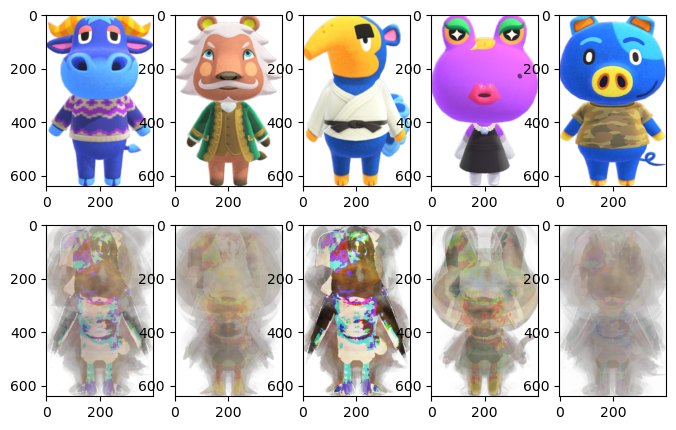

In [45]:
total = 5
plt.figure(figsize=(8, 5))

for i in range(total):
    
    # Original
    ax = plt.subplot(2, total, i+1)
    plt.imshow(X_test[i].reshape(height, width, 4))
    
    # Autoencoder result
    ax = plt.subplot(2, total, i+1+total)
    plt.imshow(predictions[i].reshape(height, width, 4))

plt.show()

## Inspecting latent vector space

Explore the latent space. 

The below was drawn from the notebook from week4 (ConvolutionalVAE) as well as from ChatGPT. 

### Example test image and its reconstruction

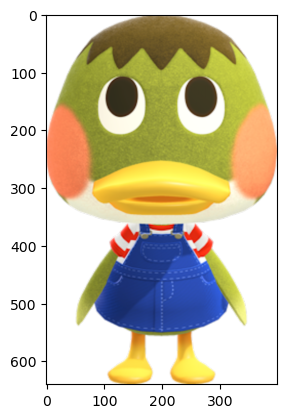

In [46]:
index = 54 #random index
test_img = X_test[index]
test_img_arr = np.asarray([test_img])

plt.imshow(test_img.reshape(height, width, 4))

In [47]:
print(test_img.shape)

test_img = np.reshape(test_img, (1, original_dim))

# Analyze the latent vector from the encoder 
encoder_result = encoder.predict(test_img)
latent_vector = encoder_result[-1]
print(latent_vector.shape)

print(latent_vector)


(1024000,)
1/1 [==============================] - 0s 87ms/step
(1, 2)
[[83.73761 91.02503]]


1/1 [==============================] - 0s 41ms/step
(1, 1024000)


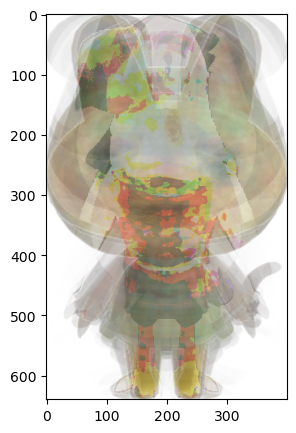

In [48]:
# Reconstruct the image from that latent vector 

decoder_img = decoder.predict(latent_vector)
print(decoder_img.shape) #this is (79,1024000)
plt.figure(figsize=(8,5))
plt.imshow(decoder_img.reshape(640,400,4))           

### Testing new latent vectors

This code was written with the help of ChatGPT.

In [49]:
# test a new latent vector
new_latent = [[-100.0, 100]]
new_decoded = decoder.predict(new_latent)

1/1 [==============================] - 0s 27ms/step


In [50]:
print(new_decoded.shape)

(1, 1024000)


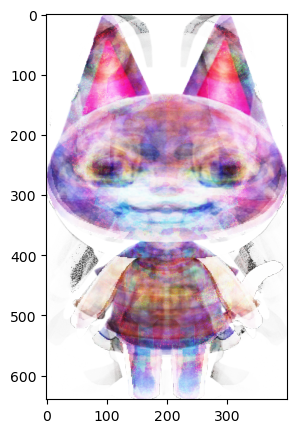

In [51]:
plt.figure(figsize=(8,5))
plt.imshow(new_decoded.reshape(640,400,4))           

### Generating random latent vectors in the correct range

Using the min and max latent vector, generate 10 new vectors and pass these into the decoder, then visualise these images. 

This was written with the help of ChatGPT. 

In [52]:
# Get the range of latent vectors from the training set 

training_latent_vectors_2 = encoder.predict(X_train)[-1]
min_latent_vector_2 = np.min(training_latent_vectors_2)
max_latent_vector_2 = np.max(training_latent_vectors_2)

print(min_latent_vector_2)
print(max_latent_vector_2)

10/10 [==============================] - 0s 43ms/step
-204.3936
305.95938


In [53]:
num_samples = 10

# Generate random latent vectors in the range of the training set 
latent_vectors_2 = np.random.randint(low=min_latent_vector_2, 
                                     high=max_latent_vector_2, 
                                     size=(num_samples,latent_dim))
print(latent_vectors_2)

# Generate images from the latent vectors using the decoder
generated_images_2 = decoder.predict(latent_vectors_2)

[[-198  -60]
 [  69   -3]
 [ 227 -194]
 [-118 -105]
 [-155  256]
 [  51  209]
 [   0   48]
 [ 174  292]
 [ 133  203]
 [-128  217]]
1/1 [==============================] - 0s 53ms/step


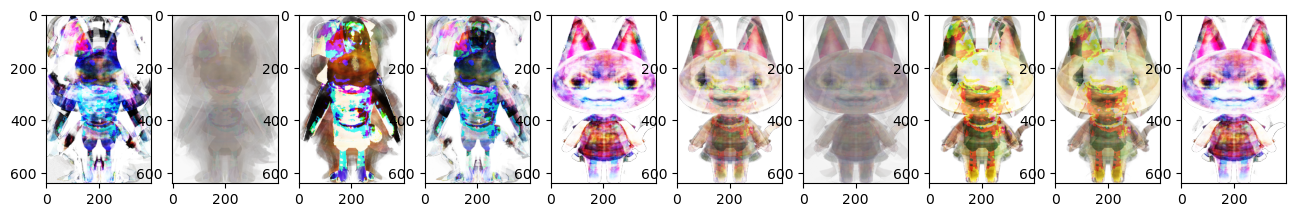

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=num_samples, figsize=(16, 16))

for i, ax in enumerate(axes):
    ax.imshow(generated_images_2[i].reshape(height, width, 4))

plt.show()